# BASICS OF MOBILE ROBOTICS
## BOMR Project

This project was made by the Group 31, made up of the following people:

### Axel Béguelin, Lou De Bel-Air, Robin Carlet, Robin Junod.

For this project of mobile robotics, we were asked to use a ThymioII robot, a camera and our project had to use the following concepts:

- Vision
- Global Navigation
- Motion Control
- Filtering
- Local Navigation

Just a quick resume of the robot. Thymio II is an educational robot in the 100 Euros price range. The robot was developed at the EPFL in collaboration with ECAL, both in Lausanne, Switzerland (wiki source). This robot has the following features:

- 2 DC-motors (and 2 Wheels)
- 39 leds
- 1 loud speaker

and has the following sensor:
- 9 infrared (IR) proximity sensors (reach about 10cm)
- 5 capacitive touch buttons
- 1 three-axis accelerometer
- 1 thermometer
- 1 microphone (recording or detection of noise)
- 1 IR receiver (for remote controller)
- 1 Wireless module

![SNOWFALL](img_presentation/img_thymio.png)

# Introduction of our project

We decided to choose the follwing project with the following setup. The goal of the thymio is to go from any position on a map to an objective.

## MOTION CONTROL

For the motion control, we used a PID controller that was used to smooth the robot trajectory. This PID controller is working on the angle error between the direction of the robot and the goal direction. A PI controller would have been probabely sufficiant but we decided to use a PID to have more freedom for the tuning.

This PID controller is comparing the angle error and give as output a 'rotation' delta speed. This rotation speed will then be add/substated to the left and right motor speed. To have something has bellow:
<div>
<img src="img_presentation/pid_resume.png" width="300"/>
</div>

For the computation of the angle error, we need the follwing information:
- robot position
- angle of the robot
- goal position

We represent the postion in the classical cartesian coordinates (x,y). The angle of the thymio(alpha) and the angle of the goal(alpha_goal) as 'absolut angle'. The vector (1,0) has the angle 0 (the vector (0,1) as the angle pi/2 etc...). The angle is negative in clockwise direction. The angle error is always represented in the range : [-pi , pi], This way, the PID controller is easy to implement. The image below is presenting the general idea of the PID implementation:

<div>
<img src="img_presentation/PID_details.png" width="500"/>
</div>

The motion control part is made in a class of .py file. For further information, go look at the script: functiion.MotionControl.py.

In [1]:
import function.MotionControl as MotionControl
import matplotlib.pyplot as plt
import math

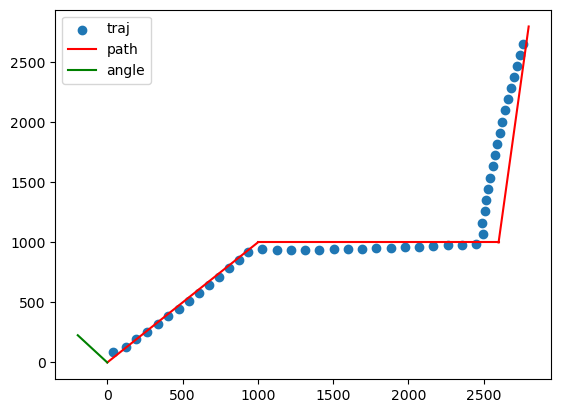

In [2]:
# Here is an exemple trajectory of the implemetation of the PID without the filtered feedback about the position and angle.
# For this exemple, we take only the 

goals_list = [(1000,1000), (2600,1000),(2800,2800)]
n_goal = 0
goal_pos = list(goals_list[n_goal])

init_robot_angle = -4
robot_speed = [100,100]
robot_angle = -4
robot_pos = [0,0]

d_time = 3
thymio_trajectory = []

# Create PID controller
PID = MotionControl.MotionControl()
PID.update_angle_error(robot_angle, robot_pos, goals_list[n_goal])
# loop
loop = 0
while True:
    loop += 1
    goal_achieved = False
    # compute error
    PID.update_angle_error(robot_angle, robot_pos, goal_pos)
    # compute PID speed
    [robot_speed[0], robot_speed[1]] = PID.PID(d_time, 100, 100)
    # set speed and get new position and angle value
    [robot_pos[0], robot_pos[1], robot_angle] = PID.plant(robot_speed[0], robot_speed[1], robot_pos[0], robot_pos[1], robot_angle, d_time)
    thymio_trajectory.append((robot_pos[0], robot_pos[1]))
    
    # Check proximity
    manathan_dist_to_goal = abs(goal_pos[1]-robot_pos[1]) + abs(goal_pos[0]-robot_pos[0])
    if manathan_dist_to_goal < 200 or loop > 300:
        n_goal += 1
        if n_goal < len(goals_list):
            goal_pos = list(goals_list[n_goal])
            # reset integral value
            PID.PID_integral = 0
        else:
            break

# plot trajectorie
plt.scatter(*zip(*thymio_trajectory), label='traj')
# Plot objective 'path'
# Plot objective 'path'
plt.plot([0,goals_list[0][0]], [0,goals_list[0][1]], color = 'red', linestyle = 'solid', label='path')

plt.plot([goals_list[0][0],goals_list[1][0]], [goals_list[0][1],goals_list[1][1]], color = 'red', linestyle = 'solid', label=None)
plt.plot([goals_list[1][0],goals_list[2][0]], [goals_list[1][1],goals_list[2][1]], color = 'red', linestyle = 'solid', label=None)

plt.plot([0,300*math.cos(init_robot_angle)], [0, 300 * math.sin(init_robot_angle)], color = 'green', label='angle')


plt.legend()

#plt.title('Thymio PID direction')

# Threading and code organisation

We decided to use a threads for the data aquisition of the thymio. In this way we don't need to wait on the thymio for the information on the thymio speed and the sensors. Thoses computation can be done in parallel so we can compute simultaneously the vison/motioncontrol. 

The two threads we created are the following ones:
- thread_update_odometry 
- thread_get_sensor

The odomerty threads takes the values of the motors speed and compute the relative position/angle of the thymo. It then returns the results in the globa variables ODOMERTY. In this way, this Global variable will be updated and can be reused in other threads for other computation.

The get sensor thread is a simplier threads that only read the sensor values and returns it also in a global varaible (PROX_SENSOR). 

In that way we have 2 global variables that are updated and accecible at anytime.

We decided to use threads, because the reading variables for the sensor can take up to 100ms. If we had a all in a simple loop, this would make the whole programm wait for those sensor values.
The main thread is the loop in the main file. In this part we are computing the follwing parts: visualisation, filtering and the controller.


<div>
<img src="img_presentation/threads_.png" width="500"/>
</div>


# Odomerty

As said before, we are computing the updating the odomerty in a threads and the result is saved into a gloval variable. Another thing to notice is that this global variable ODOMERTY is also update after the filtering. This means that this ODOMERTY variable doesn't rely only on the motor speed but is also modified by the vision. With this techinique the error of the odomerty is not incresing across time (it is when the odomertry is running on its own but is adjusted as soon as it goes into the filtering).

Now let's look the thread update odomerty into details. The goal here is to estimated the postition of the robot knowing the speed of the right and left motors. For this we made the follwing computation and hypothesis:

<div>
<img src="img_presentation/odometry.png" width="800"/>
</div>

This 